# Computing metrics on generated responses

Basically here I have sifted through and organised the results from two models (ift and base) over the same prompts, and computed some measures to compare their "generation quality".

Given `j` prompts and `i` generations per prompt, I computed the `self-bleu` score of all `i` responses across `j` prompts. Similarly I also computed the `repetition-ratio` for each generation, grouping and averaging by prompt.

TODO: compute gender bias metrics and see if there are overlaps?

In [1]:
import json
import pandas as pd
from pathlib import Path

root_dir = Path.cwd().parent
data_dir = root_dir / "data"
OUTPUT_FILE = data_dir / "output.jsonl"

import nltk
from nltk.tokenize import word_tokenize

In [2]:
### utils

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    df = pd.DataFrame(data)
    return df


### compute `repetition_ratio`

In [3]:
def repetition_ratio(response, n=3) -> float:
    """
    Calculate the repetition ratio of words in a response.
    
    Args:
        response (str): The generated response text.
        n (int): n-gram size to consider for repetition; default=3.
        
    Returns:
        float: Ratio of repeated words to total words in response
    """
    tokens = word_tokenize(response.lower())
    
    ngrams = list(nltk.ngrams(tokens, n))
    total_ngrams = len(ngrams)
    unique_ngrams = len(set(ngrams))

    rr = 1 - (unique_ngrams / total_ngrams) if total_ngrams > 0 else 0.0
    return rr

### compute `self_bleu`

In [4]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def self_bleu(responses: list[str]) -> float:
    """
    calculate self-BLEU across responses.
    
    Args:
        responses: List of response texts
    
    Returns:
        avg self-BLEU score (0-1, lower = more diverse)
    """
    if len(responses) < 2:
        return 0.0
    
    smoothing = SmoothingFunction()
    scores = []
    
    for i, response in enumerate(responses):
        hypothesis = word_tokenize(response.lower())
        references = [
            word_tokenize(responses[j].lower()) 
            for j in range(len(responses)) if j != i
        ]
        
        score = sentence_bleu(
            references,
            hypothesis,
            smoothing_function=smoothing.method1
        )
        scores.append(score)
    
    return sum(scores) / len(scores)

## aggregate and visualise results

just use pandas

### Plot results from both models

Text(0.5, 1.0, 'Self-BLEU Scores by Profile ID')

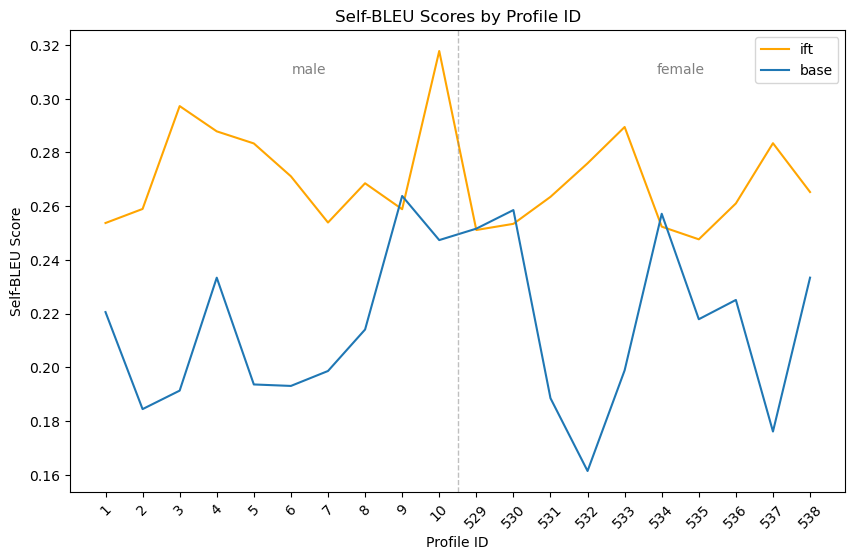

In [24]:
output_data = read_jsonl(OUTPUT_FILE)
n_grams = [1, 2, 3, 4]

# get responses for each model
ift_responses = output_data[output_data['model'] == 'ift']['response'].tolist()
base_responses = output_data[output_data['model'] == 'base']['response'].tolist()

# get responses per prompt/profile
responses_by_id_ift = {i: output_data[(output_data['profile_id'] == i) & 
                                      (output_data['model'] == 'ift')]['response'].tolist() 
                                      for i in output_data['profile_id'].unique()}
responses_by_id_base = {i: output_data[(output_data['profile_id'] == i) & 
                                       (output_data['model'] == 'base')]['response'].tolist() 
                                       for i in output_data['profile_id'].unique()}
# compute self-bleu per profile
self_bleu_ift = {i: self_bleu(responses) for i, responses in responses_by_id_ift.items()}
self_bleu_base = {i: self_bleu(responses) for i, responses in responses_by_id_base.items()}

# plot results for self-bleu
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
profile_ids = list(self_bleu_ift.keys()) # get numerical keys for plotting
plt.plot(range(len(profile_ids)), self_bleu_ift.values(), color='orange', label='ift')
plt.plot(range(len(profile_ids)), self_bleu_base.values(), label='base')

# add vertical divider between the two gender groups
# position at x=10.5 (between index 10 and 529)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# add gender labels
plt.text(5.5, plt.ylim()[1]*0.95, 'male', ha='center', fontsize=10, color='gray')
plt.text(15.5, plt.ylim()[1]*0.95, 'female', ha='center', fontsize=10, color='gray')

# fix x_ticks to show profile ids
plt.xticks(range(len(profile_ids)), profile_ids, rotation=45)

plt.xlabel('Profile ID')
plt.ylabel('Self-BLEU Score')
plt.legend()
plt.title('Self-BLEU Scores by Profile ID')

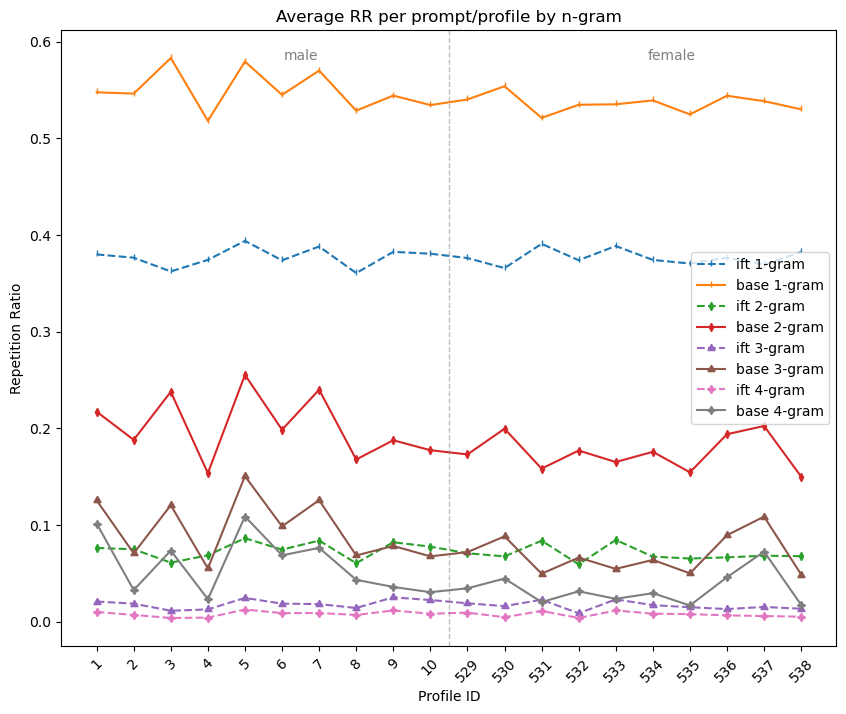

In [25]:
# plot results for repetition ratio
import matplotlib.pyplot as plt
import numpy as np

# organise data by profile_id
profile_ids = sorted(output_data['profile_id'].unique(), key=int)
rr_by_profile_ift = {n: [] for n in n_grams}
rr_by_profile_base = {n: [] for n in n_grams}

for profile_id in profile_ids:
    profile_responses_ift = output_data[(output_data['profile_id'] == profile_id) & 
                                    (output_data['model'] == 'ift')]['response'].tolist()
    profile_responses_base = output_data[(output_data['profile_id'] == profile_id) & 
                                     (output_data['model'] == 'base')]['response'].tolist()
    for n in n_grams:
        avg_rr_ift = np.mean([repetition_ratio(resp, n=n) for resp in profile_responses_ift])
        rr_by_profile_ift[n].append(avg_rr_ift)
        avg_rr_base = np.mean([repetition_ratio(resp, n=n) for resp in profile_responses_base])
        rr_by_profile_base[n].append(avg_rr_base)

# Plot
plt.figure(figsize=(10, 8))
for n in [1, 2, 3, 4]:
    plt.plot(range(len(profile_ids)), rr_by_profile_ift[n], marker=(n, 1, 0), linestyle='dashed', label=f'ift {n}-gram')
    plt.plot(range(len(profile_ids)), rr_by_profile_base[n], marker=(n, 1, 0), label=f'base {n}-gram')

# add vertical divider between the two gender groups
# position at x=10.5 (between index 10 and 529)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# add gender labels
plt.text(5.5, plt.ylim()[1]*0.95, 'male', ha='center', fontsize=10, color='gray')
plt.text(15.5, plt.ylim()[1]*0.95, 'female', ha='center', fontsize=10, color='gray')

# fix x_ticks to show profile ids
plt.xticks(range(len(profile_ids)), profile_ids, rotation=45)

plt.xlabel('Profile ID')
plt.ylabel('Repetition Ratio')
plt.title('Average RR per prompt/profile by n-gram')
plt.legend()
plt.show()
